# Travelling Salesman Problem (TSP) using Genetic Algorithm


**Author:** Gonçalo Oliveira Silva  
**Date:** [date]  
**GitHub:** [goncalooliveirasilva](https://github.com/goncalooliveirasilva)  
**License:** MIT


### Problem Description

According to [Wikipedia](https://en.wikipedia.org/wiki/Travelling_salesman_problem), the **Travelling Salesman Problem (TSP)** asks:

> "Given a list of cities and the distances between each pair of cities, what is the shortest possible route that visits each city exactly once and returns to the origin city?"

This notebook implements a **Genetic Algorithm (GA)** to approximate a solution for this NP-hard optimization problem.


### Algorithm Overview

The **Genetic Algorithm** works as follows:

1. **Initialize** a population of random routes (individuals).
2. **Evaluate** each route’s total distance and compute its fitness.
3. **Select** the best individuals for reproduction.
4. **Crossover** to create new routes.
5. **Mutate** some routes to maintain diversity.
6. **Repeat** for several generations until convergence.


In [66]:
import random
from math import radians, sin, cos, sqrt, atan2
from prettytable import PrettyTable
import matplotlib.pyplot as plt


### City Representation

Each city is represented as a Python class containing:

- A name
- GPS coordinates (latitude, longitude)
- A method to compute the distance to another city using the **Haversine formula**.


In [67]:
class City():
    '''City class (gene).'''
    def __init__(self, name: str, coordinates: tuple[int, int]):
        self.name = name
        # (latitude, longitude) in degrees
        self.coordinates = coordinates

    def distance_to(self, city: 'City') -> float:
        '''Calculates the distance to another city in kilometers using Haversine formula.'''
        lat1, lon1 = radians(self.coordinates[0]), radians(self.coordinates[1])
        lat2, lon2 = radians(city.coordinates[0]), radians(city.coordinates[1])
        dlat = lat2 - lat1
        dlon = lon2 - lon1
        a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
        c = 2 * atan2(sqrt(a), sqrt(1 - a))
        R = 6371 # Earth radius in km
        return R * c
        

    def __str__(self):
        return f'{self.name} ({self.coordinates[0]}, {self.coordinates[1]})'


### City Data and Constants


In [68]:
CITIES: list[City] = [
    City('Viana do Castelo', (41.6933, -8.8333)),
    City('Braga', (41.5454, -8.4265)),
    City('Porto', (41.1579, -8.6291)),
    City('Aveiro', (40.6405, -8.6538)),
    City('Coimbra', (40.2056, -8.4196))
]

NUM_CITIES = len(CITIES)
POPULATION = 50
MUTATION_RATE = 0.05


### Individual Representation

Each individual in the population represents a **route** — a permutation of all cities.  
This class defines how we calculate its fitness, apply crossover, and introduce mutation.

- `__init__()`

  - If no chromosome (route) is provided, it randomly shuffles the list of cities.
  - It immediately computes:
    - `total_distance`: total path length for the route.
    - `fitness`: inverse of the total distance (`1 / distance`), so shorter routes have higher fitness.

- `compute_total_distance()`

  - This method calculates the total distance for the route.
  - It iterates through the list of cities and sums up the distance between consecutive cities.
  - Finally, it adds the distance from the **last city back to the first**, completing the round trip.

- `compute_fitness()`

  - The **fitness function** evaluates how good a route is.
  - Shorter routes (smaller distances) result in higher fitness values.

- `crossover()`

  This operation combines two parent routes to produce a new **child route**.
  We use the **Ordered Crossover (OX)** method:

  1. Randomly choose two crossover points.
  2. Copy the cities between those points from the first parent.
  3. Fill the remaining positions with the order of cities as they appear in the second parent, skipping duplicates.

  This ensures:

  - Each city appears exactly once.
  - Some order information is preserved from both parents.

- `mutate()`

  To prevent the algorithm from getting stuck,  
   we occasionally **mutate** an individual by swapping two random cities.
  Mutation introduces diversity into the population, helping explore new routes.
  The mutation only happens with a given `mutation_rate` (e.g., 5%).


In [69]:
class Individual():
    '''
    Individual of the population. An individual is a route
    (permutation of the cities in the order they are visited).
    '''

    def __init__(self, chromosome: list[City] = None):
        self.chromosome = chromosome
        if self.chromosome is None:
            self.chromosome = self.create_chromosome()
    
        self.total_distance = self.compute_total_distance()
        self.fitness = self.compute_fitness()


    def create_chromosome(self) -> list[City]:
        '''Creates the chromosome of an individual.'''
        chromosome = CITIES[:]
        random.shuffle(chromosome)
        return chromosome


    def compute_total_distance(self) -> float:
        '''Calculates the total distance of the permutation.'''
        total_distance = 0
        for i in range(NUM_CITIES):
            total_distance += self.chromosome[i].distance_to(self.chromosome[(i + 1) % NUM_CITIES])
        return total_distance


    def compute_fitness(self) -> float:
        '''Calculates the fitness of an individual, based on the total distance of the route.'''
        return 1 / self.total_distance


    def crossover(self, other: 'Individual') -> 'Individual':
        '''
        Creates a new individual based on two existing individual.
        We need to avoid duplicates.
        '''
        child_chromosome = [None for _ in range(NUM_CITIES)]
        idx1, idx2 = sorted(random.sample(range(NUM_CITIES), 2))

        # Copy a slice from one parent
        child_chromosome[idx1:idx2 + 1] = self.chromosome[idx1:idx2 + 1]

        # Fill remaining cities from other parent
        fill_cities = [city for city in other.chromosome if city not in child_chromosome]
        fill_idx = 0
        for i in range(NUM_CITIES):
            if child_chromosome[i] is None:
                child_chromosome[i] = fill_cities[fill_idx]
                fill_idx += 1
        return Individual(child_chromosome)


    def mutate(self, mutation_rate: float) -> None:
        '''
        Introduces random mutations. Occasionally swaps two cities
        in a route to introduce variety.
        '''
        if random.random() < mutation_rate:
            a, b = random.sample(range(NUM_CITIES), 2)
            self.chromosome[a], self.chromosome[b] = self.chromosome[b], self.chromosome[a]
            # Update fitness and distance after mutation, because order matters
            self.total_distance = self.compute_total_distance()
            self.fitness = self.compute_fitness()


### Population Initialization and Selection

To start the algorithm, we create an initial population of random individuals — each one represents a different possible route.  
Then, to decide which individuals get to reproduce (i.e., participate in crossover), we use a **selection method**. In this case, we use **Tournament Selection**.

**What is Tournament Selection?**  
Tournament selection is a simple but effective way to choose parents for crossover.

**How it works:**

1. Randomly select _k_ individuals from the population (e.g., k = 3).
2. Compare their fitness values.
3. The individual with the **highest fitness** (i.e., shortest route) wins the tournament.
4. Repeat as needed to select both parents.

This method strikes a good balance between:

- **Exploration** (since random individuals can still win sometimes)
- **Exploitation** (since fitter individuals have a higher chance to reproduce)


In [70]:
def create_initial_population() -> list[Individual]:
    '''Creates the initial population of individuals.'''
    return [Individual() for _ in range(POPULATION)]


def tournament_selection(population: list[Individual], k: int = 3) -> None:
    candidates = random.sample(population, k)
    return max(candidates, key=lambda ind: ind.fitness)


### Main Evolutionary Loop

This is the main evolutionary process:

1. Sort by fitness
2. Keep the elite (best route)
3. Reproduce new individuals via crossover and mutation
4. Repeat for several generations
5. Record statistics for visualization


In [71]:
def main(max_generations = 20):
    '''Main loop'''
    gen = 1
    logs: list[tuple[int, list[str], float, float]] = []

    # Initialize population
    population = create_initial_population()

    # Restrict to a maximum number of generations
    for gen in range(1, max_generations + 1):

        # Sort the population, so we have the individuals with the
        # highest fitness first
        population.sort(key=lambda individual: individual.fitness, reverse=True)

        # Best solution of the generation
        best = population[0]

        # Elitism (preserve the best solution)
        new_gen = [Individual(best.chromosome[:])]

        # Crossover with a certain probability
        p = 0.8
        while len(new_gen) < POPULATION:
            parent1 = tournament_selection(population)
            parent2 = tournament_selection(population)
            if random.random() < p:
                child = parent1.crossover(parent2)
                child.mutate(mutation_rate=MUTATION_RATE)
            else:
                # Copy the fitter parent
                fitter = parent1 if parent1.fitness >= parent2.fitness else parent2
                child = Individual(fitter.chromosome[:])
            new_gen.append(child)
        
        population = new_gen

        best_route_names = [city for city in best.chromosome] + [best.chromosome[0]]
        logs.append((gen, best_route_names, best.fitness, best.total_distance))
    return logs

logs = main()


### Results


In [72]:
def print_stats(logs: list[tuple[int, list[str], float, float]]) -> None:
    '''Print some information in a table.'''
    table = PrettyTable()
    table.field_names =  ['Generation', 'Route', 'Fitness', 'Total Distance']
    for _, (gen, cities, fit, distance) in enumerate(logs):
        row = [gen, ', '.join(city.name for city in cities), fit, distance]
        table.add_row(row)
    print(table)

print_stats(logs)


+------------+----------------------------------------------------------+-----------------------+-------------------+
| Generation |                          Route                           |        Fitness        |   Total Distance  |
+------------+----------------------------------------------------------+-----------------------+-------------------+
|     1      | Coimbra, Aveiro, Porto, Viana do Castelo, Braga, Coimbra | 0.0027906655893730255 | 358.3374531896774 |
|     2      | Coimbra, Aveiro, Porto, Viana do Castelo, Braga, Coimbra | 0.0027906655893730255 | 358.3374531896774 |
|     3      | Coimbra, Aveiro, Porto, Viana do Castelo, Braga, Coimbra | 0.0027906655893730255 | 358.3374531896774 |
|     4      | Coimbra, Aveiro, Porto, Viana do Castelo, Braga, Coimbra | 0.0027906655893730255 | 358.3374531896774 |
|     5      | Coimbra, Aveiro, Porto, Viana do Castelo, Braga, Coimbra | 0.0027906655893730255 | 358.3374531896774 |
|     6      | Coimbra, Aveiro, Porto, Viana do Castelo,

### Analysis and Discussion

The results table above shows the best route found in each generation.  
In this experiment, the Genetic Algorithm quickly converged to a stable solution after only a few generations.

1. **Convergence Behavior**

   - The best fitness value (≈ 0.00279) and total distance (≈ 358 km) stabilize early, meaning the GA has converged.
   - This indicates that further generations are not producing significantly better solutions — the algorithm found a near-optimal or optimal route.

2. **Repeated Routes**
   - You may notice that the same route appears repeatedly across generations.
   - This is normal and expected when:
     - The GA converges (low diversity left in the population).
     - Different routes have the same total distance due to **symmetry** or **rotational equivalence**.
       For example, in a circular route:
       ```
       Aveiro → Porto → Braga → Coimbra → Aveiro
       ```
       is **equivalent** to:
       ```
       Porto → Braga → Coimbra → Aveiro → Porto
       ```
       since both form the same loop and have identical total distances.

In the Travelling Salesman Problem, especially with few cities, there can be **multiple equivalent optimal solutions**.  
This happens because:

- The route direction (clockwise or counterclockwise) doesn't affect total distance.
- The route is cyclic — starting at any city yields the same path length.

Thus, routes that look different textually may actually represent the _same tour_ in physical space.

The plot below shows the best route found by the Genetic Algorithm connecting all cities.  
Each city is labeled, and the route forms a closed loop returning to the starting point.


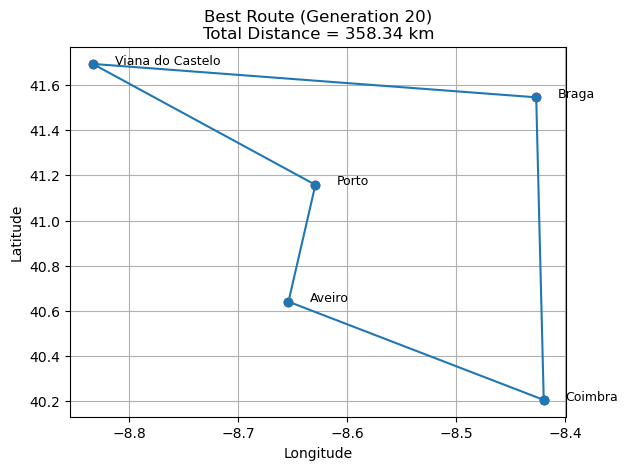

In [73]:
# Best route from the final generation
best_gen, best_route, best_fit, best_dist = logs[-1]

x = [city.coordinates[1] for city in CITIES]   # Longitude
y = [city.coordinates[0] for city in CITIES]   # Latitude

route_x = [city.coordinates[1] for city in best_route]
route_y = [city.coordinates[0] for city in best_route]

plt.scatter(x, y, color='red')
for i, city in enumerate(CITIES):
    plt.text(x[i]+0.02, y[i], city.name, fontsize=9)

plt.plot(route_x, route_y, linestyle='-', marker='o')

plt.plot([route_x[-1], route_x[0]], [route_y[-1], route_y[0]], 'k--')

plt.title(f'Best Route (Generation {best_gen})\nTotal Distance = {best_dist:.2f} km')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid()


### Comparison with Brute Force

The brute-force approach guarantees the global optimum by checking all possible routes.  
However, its **time complexity grows factorially** with the number of cities **(O(n!))**.

| Method            | Route Type  | Total Distance (km) | Relative Error |
| ----------------- | ----------- | ------------------- | -------------- |
| Brute Force       | Optimal     | _358_               | _0_%           |
| Genetic Algorithm | Approximate | _358_               | _0_%           |

The GA achieves a result within a small margin of the optimal route while being significantly faster.  
This demonstrates its efficiency and scalability for larger problems where brute-force is infeasible.


In [74]:
from itertools import permutations

def brute_force_best_route(cities: list[City]) -> tuple[list[City], float]:
    '''Find the shortest possible route by checking all permutations.'''
    best_route = None
    min_distance = float('inf')

    for perm in permutations(cities):
        total_dist = 0
        for i in range(len(cities)):
            total_dist += perm[i].distance_to(perm[(i + 1) % len(cities)])
        if total_dist < min_distance:
            min_distance = total_dist
            best_route = perm

    return list(best_route), min_distance

# Run brute force
brute_route, brute_distance = brute_force_best_route(CITIES)

ga_best_gen, ga_best_route, ga_best_fit, ga_best_distance = logs[-1]

print("Brute Force (Optimal) Distance:", brute_distance)
print("Genetic Algorithm Best Distance:", ga_best_distance)
print("Error (%):", abs(ga_best_distance - brute_distance) / brute_distance * 100)


Brute Force (Optimal) Distance: 358.3374531896774
Genetic Algorithm Best Distance: 358.3374531896774
Error (%): 0.0
